# Pills Segmentation

**University of Milano-Bicocca**

*Vision for Industry and Environment*

**Michele Ventimiglia**

---

## Project Assessment

### Dataset: MVTec AD (category `bottle`)

MVTec AD ([Dataset URL](https://www.mvtec.com/company/research/datasets/mvtec-ad)) is an industrial benchmark for anomaly detection and defect segmentation.

For the provides high-resolution RGB images of real industrial objects, with pixel-wise annotations for defects.

The `bottle` category represents plastic bottles (`1:1,900px`) used in packaging, photographed from above with controlled lighting to simulate inspection scenarios on production lines.

**Main statistics**

| Split  | Good images | Defective images | Total | Defect masks |
|--------|-------------|-----------------|-------|--------------|
| Train  | 209         | 0                | 209   | -            |
| Test   | 20          | 133              | 153   | 133          |

> Defect types in the test set: `broken_large`, `broken_small`, `contamination`

**Folder structure**

```txt
bottle/
 ├── train/
 │   └── good/
 ├── test/
 │   ├── good/
 │   ├── broken_large/
 │   ├── broken_small/
 │   └── contamination/
 └── ground_truth/
     ├── broken_large/
     ├── broken_small/
     └── contamination/
```

- The masks in `ground_truth/` are binary images with white pixels where there is a defect and black pixels elsewhere, same size as the original image.
- The train set contains only images with no defects (under `good/` folder), ideal for one-class techniques such as autoencoders.
- The test set contains both good and defective images, with pixel-wise masks for segmentation evaluation.

Here is an example of a good image, a defective image, and the corresponding defect mask:

<div style="display: flex; justify-content: left; gap: 30px; align-items: flex-start; text-align: center;">

  <figure style="margin: 0;">
    <img src="data/bottle/test/good/000.png" width="180" style="display: block; margin: auto;">
    <figcaption>Good</figcaption>
  </figure>

  <figure style="margin: 0;">
    <img src="data/bottle/test/broken_large/000.png" width="180" style="display: block; margin: auto;">
    <figcaption>Defect</figcaption>
  </figure>

  <figure style="margin: 0;">
    <img src="data/bottle/ground_truth/broken_large/000_mask.png" width="180" style="display: block; margin: auto;">
    <figcaption>Defect Mask</figcaption>
  </figure>

</div>

### Project motivation and objectives

**Motivation**  
The goal of this project is to detect defects in plastic bottles used in packaging in the manufacturing industry as damaged or contaminated bottles can lead to product loss, contamination risks, and customer dissatisfaction.

**Architectures**
- For `Project 1` we used a custom convolutional autoencoder trained only on good images. This architecture was chosen because it allows unsupervised learning of the "normality" of the product and detects anomalies as deviations in reconstruction, without requiring labeled defects.
- For `Project 2` (this one) we implemented a custom U-Net-based segmentation model (lightweight U2NETMini style). This architecture was selected for its ability to capture multi-scale features and produce accurate pixel-wise masks, with a compact design suitable for industrial deployment.

**Objectives**  
- Develop and train from scratch custom models (without pre-trained backbones) for anomaly detection and defect segmentation.
- Compare two different strategies: classification and segmentation.
- Achieve at least `90%` accuracy.
- Provide a reproducible pipeline that could be adapted to real production settings.

---

## Setup

### Requirements

Check if pytorch is already installed, otherwise we install it via `pip`:

In [1]:
try:
    import torch
    print("PyTorch is already installed.")
except ImportError:
    print("PyTorch is not installed. Installing now...")
    %pip install -q --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128

PyTorch is already installed.


Install the dependencies from `requirements.txt`:

In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Import all the required dependancies:

In [ ]:
# Standard Libraries
import os
import gc
import sys
import random
from pathlib import Path
from functools import lru_cache
from typing import Tuple, Optional

# Third-Party Packages
import cv2
import torch
import sklearn
import numpy as np
import torch.nn as nn
from torch import Tensor
from tqdm.auto import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.amp import autocast, GradScaler
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    f1_score,
    accuracy_score, 
    precision_score,
    recall_score
)

In [5]:
print(f"Python Version:\t\t{sys.version.split()[0]}")
print(f"PyTorch Version:\t{torch.__version__}")
print(f"scikit-learn Version:\t{sklearn.__version__}")

Python Version:		3.12.10
PyTorch Version:	2.8.0.dev20250615+cu128
scikit-learn Version:	1.7.0


### Configuration

Set a seed for reproducibility:

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensuures reproducibility
torch.backends.cudnn.benchmark = False  # Disables auto-tuning for performance

Check if `CUDA` is available and set the device:

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Check existence of `checkpoints/2` folder, if not, create it:

In [8]:
CHECKPOINT_DIR = "checkpoints/2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

### Dataset

Set the dataset directory:

In [9]:
DATA_DIR = Path(os.path.join(os.getcwd(), "data", "bottle"))

---

## Pre-Processing

### Custom Dataset for Segmentation: `BottleSegDataset`

The `BottleSegDataset` class is a **custom PyTorch Dataset** designed to support **pixel-wise segmentation tasks**, where the goal is to predict a binary mask indicating the location of defects.

**Key Features**
- **Unified loading** of both good and defective images from the `train` and `test` folders.
- Supports **defect categories**: `broken_large`, `broken_small`, `contamination`.
- Handles **ground-truth binary masks** for defective images, with `None` for good samples.
- Includes built-in support for:
  - **Resizing** and **normalization**
  - **Data augmentation** (e.g., flip, rotation, contrast)
  - **Oversampling** of defect images to address class imbalance
  - **Mask generation** for non-defective images (all-zero masks)

**Transformations**
- Images and masks are resized to `256×256` and normalized.
- Augmentation (if enabled) applies transformations like flip, rotate, and brightness adjustments.
- Each image can be **augmented multiple times** via the `augmentation_factor` parameter.

**Return Values**
- Each sample returns a tuple:
  - `image`: a tensor of shape `(3, 256, 256)`
  - `mask`: a binary tensor of shape `(1, 256, 256)`, where `1` indicates defective pixels

In [ ]:
class BottleSegDataset(Dataset):
    """
    Custom dataset for the Pill Anomaly Segmentation task.
    """
    image_size = (256, 256)  # Default image size for resizing
    defect_categories = [
        'broken_large',
        'broken_small', 
        'contamination'
    ]

    def __init__(
            self,
            data_dir: Path,
            transform: bool = True,
            augmentation_factor: int = 1,
            oversample_defects: bool = True
        ) -> None:
        """
        Initialize the dataset with paths to images and masks.\n
        ---
        ### Args
        - `data_dir` (`Path`): directory containing the dataset.
        - `transform` (`bool`): whether to apply transformations.
        - `augmentation_factor` (`int`): number of augmentations per image.
        - `oversample_defects` (`bool`): whether to oversample defect images to balance with good images.
        """
        self.data_dir = data_dir
        self.transform_enabled = transform
        self.augmentation_factor = max(1, augmentation_factor)  # Ensure at least one augmentation

        # Load all images and masks
        self.images, self.masks = self._load_images()
        if oversample_defects: self._apply_oversampling()
        self.base, self.augmentation = self._build_transform()

    def _build_transform(self) -> Tuple[A.Compose, A.Compose]:
        """
        Builds the base and augmentation transformation pipelines.\n
        ---
        Returns:
        - Tuple[A.Compose, A.Compose]: base transform, augmentation transform.
        """
        base = A.Compose([
            A.Resize(*self.image_size),
            A.Normalize(),
            ToTensorV2()
        ])

        augmentation = A.Compose([
            A.Resize(*self.image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])

        return base, augmentation

    def _load_images(self) -> Tuple[list, list]:
        """
        Load all image paths and associated masks (None if good).\n
        ---
        ### Returns
        - `images` (`list`): list of image paths.
        """
        images, masks = [], []

        # Load good images and their masks
        for split in ['train', 'test']:
            # Load good images
            for image_path in sorted((self.data_dir / split / "good").glob("*.png")):  # Ensure to use glob to find all PNG files
                images.append(image_path)
                masks.append(None)

            # Load defective images and their masks
            for category in self.defect_categories:
                defect_dir = self.data_dir / split / category
                mask_dir = self.data_dir / "ground_truth" / category
                
                # Ensure both directories exist
                if not defect_dir.exists() or not mask_dir.exists():
                    continue

                # Load defective images and their corresponding masks
                for image_path in sorted(defect_dir.glob("*.png")):
                    mask_path = mask_dir / image_path.name.replace(".png", "_mask.png")
                    if mask_path.exists():
                        images.append(image_path)
                        masks.append(mask_path)

        return images, masks

    def _apply_oversampling(self) -> None:
        """
        Duplicate defect samples to balance with good samples.
        """
        # Ensure there are defect samples to oversample
        # Collect defect samples (those with masks)
        defect_samples = [
            (image, mask)
            for image, mask in zip(self.images, self.masks)
            if mask is not None
        ]
        
        # Collect good samples (those without masks)
        good_samples = [
            (image, mask)
            for image, mask in zip(self.images, self.masks)
            if mask is None
        ]
        
        # If no good samples, return early
        if not defect_samples:
            return
        
        repetitions = max(1, len(good_samples) // len(defect_samples))  # Calculate how many times to repeat defect samples
        defect_samples *= repetitions  # Repeat defect samples to balance with good samples
        all_samples = defect_samples + good_samples  # Combine defect and good samples
        
        self.images, self.masks = zip(*all_samples)  # Unzip into images and masks
        self.images = list(self.images)
        self.masks = list(self.masks)
        self.total = len(self.images)

    def __len__(self) -> int:
        """
        Get the total number of samples in the dataset, considering augmentations.\n
        ---
        ### Returns
        - `int`: total number of samples, including augmentations.
        """
        return self.total * self.augmentation_factor

    @lru_cache(maxsize=4096)  # Cache loaded images to speed up access
    def _load_image(
            self, 
            path: str
        ) -> np.ndarray:
        """
        Load RGB image from path.\n
        ---
        ### Args
        - `path` (`str`): path to the image file.\n
        ---
        ### Returns
        - `np.ndarray`: image in RGB format.
        """
        image = cv2.imread(path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    @lru_cache(maxsize=4096)
    def _load_mask(
            self, 
            path: Optional[str],
            shape: Tuple[int, int]
        ) -> np.ndarray:
        """
        Load mask or generate empty mask.\n
        ---
        ### Args
        - `path` (`Optional[str]`): path to the mask file, or None for good images.
        - `shape` (`Tuple[int, int]`): shape of the image to match the mask.\n
        ---
        ### Returns
        - `np.ndarray`: binary mask of the same shape as the image.
        """
        # If no mask path is provided, return an empty mask
        if path is None:
            return np.zeros(shape, dtype=np.float32)  # Empty mask for good images
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
        return (mask > 127).astype(np.float32)  # Convert to binary mask

    def __getitem__(
            self, 
            idx: int
        ) -> Tuple[Tensor, Tensor]:
        """
        Get item by index, applying transformations if enabled.\n
        ---
        ### Args
        - `idx` (`int`): index of the item to retrieve.\n
        ---
        ### Returns
        - `Tuple[Tensor, Tensor]`: transformed image and mask tensors.
        """
        base_idx = idx % self.total  # Get the base index for the original image/mask
        image_path = str(self.images[base_idx])  # Convert Path to string for loading
        mask_path = str(self.masks[base_idx]) if self.masks[base_idx] else None  # Get mask path or None for good images

        image = self._load_image(image_path)
        mask = self._load_mask(mask_path, image.shape[:2])  

        # Apply transformations based on whether idx is in the augmentation range
        transform = self.augmentation if (self.transform_enabled and idx >= self.total) else self.base
        transformed: Tensor = transform(image=image, mask=mask)
        
        return transformed['image'], transformed['mask'].unsqueeze(0)

---

## Model Architecture: `Custom ResNet`

To perform high-precision defect segmentation, we adopt a **lightweight variant of U²-Net**, called `U2NetMini`. This architecture is inspired by the idea of **nested U-Nets with residual connections**, allowing efficient capture of both local and global contextual information.

It consists of:
- Two stacked `ResUNet7` modules, each a small U-Net-like encoder-decoder with dilation.
- A final output head that merges the two feature maps and upsamples to the original resolution.
- A hybrid loss function (`Focal Tversky + BCE`) to address class imbalance and pixel-wise uncertainty.

#### **BNConv**

The `BNConv` is the basic unit of our architecture. It is a **convolutional block with residual capabilities**, consisting of:

- `3×3 Convolution`
- `Batch Normalization`
- `ReLU` activation

Optionally, it supports **dilated convolutions** to increase the receptive field without downsampling. These blocks are used in both encoder and decoder paths of `ResUNet7`.

In [ ]:
class BNConv(nn.Module):
    """
    Block with BatchNorm and ReLU activation.
    Applies a convolution followed by batch normalization and ReLU activation.
    """
    def __init__(
            self, 
            in_channels: int,
            out_channels: int,
            dilation_rate: int = 1
        ) -> None:
        """
        Initialize the ResBNConv block with convolution, batch normalization, and ReLU activation.\n
        ---
        ### Args
        - `in_channels` (`int`): number of input channels.
        - `out_channels` (`int`): number of output channels.
        - `dilation_rate` (`int`): dilation rate for the convolution (default is 1, no dilation).
        """
        super().__init__()
        
        # Define the convolutional layer with specified dilation rate
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,  # 3x3 kernel
                padding=1*dilation_rate,  # Padding to maintain spatial dimensions
                dilation=1*dilation_rate
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(
            self,
            x: Tensor
        ) -> Tensor:
        """
        Forward pass through the ResBNConv block.\n
        ---
        ### Args
        - `x` (`Tensor`): input tensor with shape (batch_size, in_channels, height, width).\n
        ---
        ### Returns
        - `Tensor`: output tensor with shape (batch_size, out_channels, height, width).
        """
        return self.conv(x)

#### **ResUNet7**

`ResUNet7` is a compact U-Net-inspired module designed for efficient **feature encoding and decoding** using residual connections and dilated convolutions.

**Encoder Path**
- A sequence of 6 convolutional blocks with increasing **dilation rates**:
  - `d = 1, 2, 4, 8, 16, 32`
- Each block captures progressively **larger receptive fields** without increasing the number of parameters.
- Downsampling is performed using **MaxPooling**, allowing feature compression.

**Decoder Path**
- Symmetric decoding layers that:
  - **Upsample** feature maps (bilinear interpolation)
  - **Concatenate** with corresponding encoder features (skip connections)
  - Apply **residual convolution blocks**

**Output**
- The final output of the decoder is **added back to the shallow input features** (residual connection):  
  `output = hx1d + hx_in`

This structure helps preserve spatial resolution and accelerates training by ensuring better **gradient flow** and **feature reuse**, making it ideal for lightweight yet effective segmentation tasks.


In [ ]:
class ResUNet7(nn.Module):
    """
    Residual U-Net with 7 stages, designed for image segmentation tasks.
    This architecture includes an encoder with increasing dilation rates and a decoder that upsamples the features.
    The final output is a residual connection from the input to the output.
    """
    def __init__(
            self, 
            in_channels: int = 3, 
            mid_channels: int = 12,
            out_channels: int = 3
        ) -> None:
        """
        Initialize the ResUNet7 model with specified input, middle, and output channels.\n
        ---
        ### Args
        - `in_channels` (`int`): number of input channels (default is 3 for RGB images).
        - `mid_channels` (`int`): number of middle channels (default is 12).
        - `out_channels` (`int`): number of output channels (default is 3 for RGB images).
        """
        super().__init__()
        # Initial convolution block to process input channels
        # This block will reduce the input channels to the specified output channels
        self.resbnconv_in = BNConv(in_channels, out_channels)

        # Encoder
        self.stage1 = BNConv(
            in_channels=out_channels,  # input channels from the previous layer
            out_channels=mid_channels,  # output channels for the first stage
            dilation_rate=1  # dilation rate for the first stage (no dilation)
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,  # 2x2 pooling kernel
            stride=2,  # stride of 2 for downsampling
            ceil_mode=True  # use ceil mode to ensure output size is rounded up
        )

        self.stage2 = BNConv(mid_channels, mid_channels, dilation_rate=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.stage3 = BNConv(mid_channels, mid_channels, dilation_rate=4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.stage4 = BNConv(mid_channels, mid_channels, dilation_rate=8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.stage5 = BNConv(mid_channels, mid_channels, dilation_rate=16)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.stage6 = BNConv(mid_channels, mid_channels, dilation_rate=32)

        # Decoder
        self.stage5d = BNConv(mid_channels * 2, mid_channels, dilation_rate=16)
        self.stage4d = BNConv(mid_channels * 2, mid_channels, dilation_rate=8)
        self.stage3d = BNConv(mid_channels * 2, mid_channels, dilation_rate=4)
        self.stage2d = BNConv(mid_channels * 2, mid_channels, dilation_rate=2)
        self.stage1d = BNConv(mid_channels * 2, out_channels, dilation_rate=1)

        # Upsampling layer to increase the spatial dimensions of the feature maps
        # This layer will double the height and width of the input feature maps
        self.upsample = nn.Upsample(
            scale_factor=2,  # Scale factor of 2 to double the height and width
            mode='bilinear',  # Use bilinear interpolation for upsampling
            align_corners=True  # Align corners to maintain spatial consistency
        )

    def forward(
            self,
            x: Tensor
        ) -> Tensor:
        """
        Forward pass through the ResUNet7 model.\n
        ---
        ### Args
        - `x` (`Tensor`): input tensor with shape (batch_size, in_channels, height, width).\n
        ---
        ### Returns
        - `Tensor`: output tensor with shape (batch_size, out_channels, height, width).
        """
        hx_in = self.resbnconv_in(x)  

        hx1 = self.stage1(hx_in)
        hx = self.pool1(hx1)  # reduce spatial dimensions by half

        hx2 = self.stage2(hx)
        hx = self.pool2(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool3(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool4(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool5(hx5)

        hx6 = self.stage6(hx)

        hx5d = self.stage5d(torch.cat((self.upsample(hx6), hx5), 1))  # cat to concatenate along the channel dimension, it is a skip connection
        hx4d = self.stage4d(torch.cat((self.upsample(hx5d), hx4), 1))
        hx3d = self.stage3d(torch.cat((self.upsample(hx4d), hx3), 1))
        hx2d = self.stage2d(torch.cat((self.upsample(hx3d), hx2), 1))
        hx1d = self.stage1d(torch.cat((self.upsample(hx2d), hx1), 1))

        return hx1d + hx_in

#### **U2NetMini**

`U2NetMini` is the full segmentation model composed of two `ResUNet7` stages stacked in sequence, with a shallow output head.

**Architecture Summary**
1. `ResUNet7` Stage 1: extracts features from the original image.
2. `ResUNet7` Stage 2: refines features using an additional encoder-decoder path.
3. Final head:
   - Concatenates features from both stages
   - Applies `1×1` convolution
   - Upsamples to restore original image size (256×256)

**Output**
- Produces a **single-channel probability map** representing the pixel-wise likelihood of defect presence.

**Why this design?**
- Efficient: lightweight enough for edge/real-time deployment
- Accurate: strong pixel-wise precision and recall
- Compliant: designed and trained **without pretrained models**, fully custom

This model represents the core of our segmentation pipeline, enabling real-time and high-precision anomaly localization.


In [ ]:
class U2NetMini(nn.Module):
    """
    U2NetMini model with two ResUNet7 stages and upsampling layers.
    This model is designed for image segmentation tasks, particularly for binary segmentation.
    """
    def __init__(
            self, 
            in_channels: int = 3, 
            out_channels: int = 1
        ) -> None:
        """
        Initialize the U2NetMini model with two ResUNet7 stages and upsampling layers.\n
        ---
        ### Args
        - `in_channels` (`int`): number of input channels (default is 3 for RGB images).
        - `out_channels` (`int`): number of output channels (default is 1 for binary segmentation masks).
        """
        super().__init__()
        self.stage1 = ResUNet7(in_channels, 16, 64)
        self.stage2 = ResUNet7(64, 16, 64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        # Upsampling layer to increase the spatial dimensions of the feature maps
        # this layer will double the height and width of the input feature maps
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(128, out_channels, 1),  # 1x1 convolution to reduce channels to output channels
            nn.BatchNorm2d(out_channels),  # Batch normalization for output channels
        )
        
        self.final_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)

    def forward(
            self,
            x: Tensor
        ) -> Tensor:
        """
        Forward pass through the U2NetMini model.\n
        ---
        ### Args
        - `x` (`Tensor`): input tensor with shape (batch_size, in_channels, height, width).\n
        ---
        ### Returns
        - `Tensor`: output tensor with shape (batch_size, out_channels, height, width).
        """
        x1 = self.stage1(x)
        x2 = self.stage2(self.pool(x1))
        x3 = self.upsample(x2)
        
        out = self.conv_out(torch.cat([x1, x3], dim=1))
        return self.final_upsample(out)

**Focal Tversky Loss**
- Focuses on hard-to-segment pixels by applying a focal mechanism on the Tversky index.
- Penalizes false positives (controlled by `α`) and false negatives (controlled by `β`).
- Especially useful for detecting small or rare defects.

In [ ]:
class FocalTverskyLoss(nn.Module):
    """
    Focal Tversky Loss for handling class imbalance in segmentation tasks.
    This loss function is a variant of the Tversky loss that applies a focal mechanism to
    focus on hard-to-classify pixels, making it particularly useful for imbalanced datasets.
    """
    def __init__(
            self, 
            alpha: float = 0.7,
            beta: float = 0.3,
            gamma: float = 0.75,
            smooth: float = 1e-6
        ) -> None:
        """
        Initialize the Focal Tversky Loss with specified parameters.\n
        ---
        ### Args
        - `alpha` (`float`): weight for false positives (default is `0.7`).
        - `beta` (`float`): weight for false negatives (default is `0.3`).
        - `gamma` (`float`): focusing parameter (default is `0.75`).
        - `smooth` (`float`): small constant to avoid division by zero (default is `1e-6`).
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(
            self, 
            inputs: Tensor, 
            targets: Tensor
        ) -> Tensor:
        """
        Forward pass through the Focal Tversky Loss function.\n
        ---
        ### Args
        - `inputs` (`Tensor`): model predictions (logits).
        - `targets` (`Tensor`): ground truth binary masks.\n
        ---
        ### Returns
        - `Tensor`: computed focal Tversky loss value.
        """
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to convert logits to probabilities
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the input tensor
        targets = targets.view(targets.size(0), -1)  # Flatten the target tensor

        TP = (inputs * targets).sum(dim=1)  # True Positives
        FP = ((1 - targets) * inputs).sum(dim=1)  # False Positives
        FN = (targets * (1 - inputs)).sum(dim=1)  # False Negatives

        # Calculate Tversky index and apply focal mechanism
        # Tversky index is defined as TP / (TP + alpha * FP + beta * FN)
        # Focal Tversky loss is defined as (1 - Tversky index)
        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        focal_tversky = torch.pow((1 - tversky), self.gamma)  # power to apply the focal mechanism
        return focal_tversky.mean()

**Hybrid Focal Tversky + BCE Loss**
- Combines Focal Tversky with `Binary Cross-Entropy (BCE)` loss.
- The Tversky part focuses on structure and imbalance, while the BCE part ensures pixel-wise classification accuracy.
- The hybrid formulation allows balancing both global shape and fine pixel-level correctness.

In [15]:
class HybridFocalTverskyBCE(nn.Module):
    """
    Hybrid loss combining Focal Tversky Loss and Binary Cross-Entropy Loss.
    This loss function is designed to handle class imbalance in segmentation tasks by combining the strengths of both losses.
    The Focal Tversky Loss focuses on hard-to-classify pixels, while the Binary Cross-Entropy Loss provides a standard measure of pixel-wise classification error.
    """
    def __init__(
            self,
            alpha: float = 0.7,
            beta: float = 0.3,
            gamma: float = 0.75,
            bce_weight: float = 0.5,
            tversky_weight: float = 1.0
        ) -> None:
        """
        Initialize the HybridFocalTverskyBCE loss with specified parameters.\n
        ---
        ### Args
        - `alpha` (`float`): weight for false positives in Tversky loss (default is 0.7).
        - `beta` (`float`): weight for false negatives in Tversky loss (default is 0.3).
        - `gamma` (`float`): focusing parameter for Focal Tversky Loss (default is 0.75).
        - `bce_weight` (`float`): weight for Binary Cross-Entropy Loss (default is 0.5).
        - `tversky_weight` (`float`): weight for Focal Tversky Loss (default is 1.0).
        """
        super().__init__()
        self.bce_weight = bce_weight
        self.tversky_weight = tversky_weight
        self.ftl = FocalTverskyLoss(alpha, beta, gamma)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.bce_weight))  # Weight for positive samples

    def forward(
            self, 
            inputs: Tensor,
            targets: Tensor
        ) -> Tensor:
        """
        Forward pass through the hybrid loss function.\n
        ---
        ### Args
        - `inputs` (`Tensor`): model predictions (logits).
        - `targets` (`Tensor`): ground truth binary masks.\n
        ---
        ### Returns
        - `Tensor`: computed hybrid loss value, combining Focal Tversky Loss and Binary Cross-Entropy Loss.
        """
        loss_ftl = self.ftl(inputs, targets)
        loss_bce = self.bce(inputs, targets)
        return self.tversky_weight * loss_ftl + self.bce_weight * loss_bce

---

## Training & Evaluation

Define the helper method to plot the training history:

In [ ]:
def plot_history(history: dict) -> None:
    """
    Plot training and validation loss history with best epoch marker.\n
    ---
    ### Args
    - `history` (`dict`): dictionary containing 'train' and optionally 'val' loss history.
    """
    plt.figure(figsize=(5, 4))
    plt.plot(history['train'], label='Train Loss')

    if 'val' in history and history['val']:
        plt.plot(history['val'], label='Val Loss')
        best_epoch = np.argmin(history['val'])
        best_val = history['val'][best_epoch]
        best_label = 'Val'
    else:
        best_epoch = np.argmin(history['train'])
        best_val = history['train'][best_epoch]
        best_label = 'Train'

    # Draw best epoch marker
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best {best_label} Epoch {best_epoch+1}')
    plt.scatter(best_epoch, best_val, color='red')
    # Annotate the best value
    plt.annotate(
        text=f"{best_val:.4f}",
        xy=(best_epoch, best_val), 
        textcoords="offset points",  # offset from the point
        xytext=(0, 10),  # vertical offset
        ha='center',  # horizontal alignment
        color='red'  # color of the annotation text
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Define a method to save checkpoints of the model (e.g: during training):

In [17]:
def save_ckpt(
        tag: str,
        model: U2NetMini,
        optimizer: torch.optim.Optimizer,
        epoch: int, 
        step: int,
        best_val: float
    ) -> None:
    """
    Save model checkpoint to the specified directory.\n
    ---
    ### Args
    - `tag` (`str`): tag for the checkpoint file.
    - `model` (`U2NetMini`): model to save.
    - `optimizer` (`torch.optim.Optimizer`): optimizer state to save.
    - `epoch` (`int`): current epoch number.
    - `step` (`int`): current step (batch number inside the epoch).
    - `best_val` (`float`): best validation loss achieved so far.
    """
    torch.save(
        obj={
            "epoch": epoch,
            "step": step,
            "bestVal": best_val,
            "model": model.state_dict(),
            "optim": optimizer.state_dict()
        },
        f=f"{CHECKPOINT_DIR}/{tag}.pt"  # checkpoint file path
    )

Define a method to optimize hardware resources consumption:

In [18]:
def mr_clean() -> None:
    """
    Clean up memory by deleting unused variables and calling garbage collector.
    """
    gc.collect()  # Clear Python's garbage collector
    if torch.cuda.is_available():  
        torch.cuda.empty_cache()  # Clear CUDA memory
        torch.cuda.synchronize()  # Synchronize CUDA operations to ensure all memory is freed

#### **Hyperparameters**

To train our `U2NetMini` segmentation model effectively, we define a set of hyperparameters that control learning dynamics, regularization, and data augmentation.

| Hyperparameter        | Description |
|----------------------|-------------|
| `LEARNING_RATE`       | Initial learning rate for the optimizer (Adam). A higher LR speeds up early learning but may require decay. |
| `WEIGHT_DECAY`        | L2 regularization to prevent overfitting and promote smoother weights. |
| `BATCH_SIZE`          | Number of samples per training step. Balances memory usage and gradient stability. |
| `EPOCHS`              | Maximum number of training iterations over the full dataset. |
| `EARLY_STOP_PATIENCE`| Stop training if no improvement in validation loss after this many epochs. |
| `AUGMENTATION_FACTOR`| Number of augmented samples per original image. Boosts generalization and combats overfitting. |

These values have been chosen empirically to balance **model convergence**, **generalization**, and **training stability**.  
They can be tuned further with techniques like grid search or Bayesian optimization in future extensions of the project.

In [19]:
LEARNING_RATE = 5e-3  # Initial learning rate for the optimizer
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
AUGMENTATION_FACTOR = 3  # Number of augmentations per image

BATCH_SIZE = 24  # Batch size for training and validation
EPOCHS = 150  # Number of epochs to train the model
EARLY_STOP_PATIENCE = 5  # Number of epochs to wait for improvement before stopping training

Instanciate the model to the correct device:

In [20]:
model = U2NetMini().to(DEVICE)

#### **Adam Optimizer**

We use the **Adam (Adaptive Moment Estimation)** optimizer to train our model.  
Adam combines the benefits of:
- **Momentum**: accelerates updates in relevant directions by using the *exponential moving average* of past gradients.
- **Adaptive learning rates**: scales each parameter update based on the historical magnitude of gradients (via second moment).

It offers **fast convergence**, is **robust to noisy gradients**, and works well **out-of-the-box** for deep learning tasks like segmentation.

In [21]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)

Instanciate the loss criterion:

In [22]:
criterion = HybridFocalTverskyBCE(
    alpha=0.7,  # weight for false positives in Tversky loss
    beta=0.3,  # weight for false negatives in Tversky loss
    gamma=0.7,  # focusing parameter for Focal Tversky Loss
    bce_weight=1.0,  # weight for Binary Cross-Entropy Loss
    tversky_weight=1.0  # weight for Focal Tversky Loss
)

#### **ReduceLROnPlateau**

We use the Learning Rate Scheduler `ReduceLROnPlateau` to **automatically reduce the learning rate** when the model stops improving on the validation set.

- **Monitors**: validation loss.
- **Waits** for a few epochs (`patience`) without improvement.
- **Reduces** the learning rate by a factor (e.g., `×0.5`).
  
This helps the model **converge smoothly**, avoiding premature stagnation or overshooting during training.


In [23]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,  # learning rate scheduler to reduce learning rate on plateau
    mode='min',  # mode to monitor for reduction (minimize validation loss)
    factor=0.5,  # factor by which to reduce the learning rate
    patience=2  # number of epochs with no improvement before reducing learning rate
)

Create the dataset using our custom `BottleSegDataset` constructor:

In [24]:
dataset = BottleSegDataset(
    data_dir=DATA_DIR,
    transform=True,
    augmentation_factor=AUGMENTATION_FACTOR
)

**Denormalization**
- Reverses the normalization applied during preprocessing.
- Necessary to properly visualize the original RGB images for human interpretation.

In [38]:
def denormalize(
        tensor: Tensor, 
        mean: Tuple[float, float, float],
        std: Tuple[float, float, float]
    ) -> Tensor:
    """
    Denormalize a tensor by applying the inverse of normalization using mean and standard deviation.\n
    ---
    ### Args
    - `tensor` (`Tensor`): tensor to denormalize.
    - `mean` (`Tuple[float, float, float]`): mean values for each channel.
    - `std` (`Tuple[float, float, float]`): standard deviation values for each channel.\n
    ---
    ### Returns
    - `Tensor`: denormalized tensor.
    """
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

We deifine a method to visualize the original and augmented images with their masks:

In [ ]:
def visualize_augmentations(
        dataset: BottleSegDataset, 
        num_samples: int = 3
    ) -> None:
    """
    Visualize original and augmented images with their masks from the dataset.\n
    ---
    ### Args
    - `dataset` (`BottleSegDataset`): dataset containing images and masks.
    - `num_samples` (`int`): number of samples to visualize (default is `3`).
    """
    mean = [0.485, 0.456, 0.406]  # Mean usata per la normalizzazione
    std = [0.229, 0.224, 0.225]  # Std usata per la normalizzazione

    for i in range(num_samples):
        # Get the original image and mask
        image, mask = dataset[i]
        
        # Denormalize the original image and mask
        original_image = denormalize(image, mean, std)
        original_image_np = original_image.permute(1, 2, 0).numpy().clip(0, 1)
        original_mask_np = mask.squeeze().numpy()

        # Get the augmented image and mask
        augmented_image, augmented_mask = dataset[i + len(dataset)]
        augmented_image = denormalize(augmented_image, mean, std)
        # Convert tensors to numpy arrays for visualization
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy().clip(0, 1)
        augmented_mask_np = augmented_mask.squeeze().numpy()

        # Plot original and augmented images with their masks
        _, ax = plt.subplots(1, 4, figsize=(8, 2))
        ax[0].imshow(original_image_np)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(original_mask_np, cmap="gray")
        ax[1].set_title("Original Mask")
        ax[1].axis("off")

        ax[2].imshow(augmented_image_np)
        ax[2].set_title("Augmented Image")
        ax[2].axis("off")

        ax[3].imshow(augmented_mask_np, cmap="gray")
        ax[3].set_title("Augmented Mask")
        ax[3].axis("off")

        plt.tight_layout()
        plt.show()

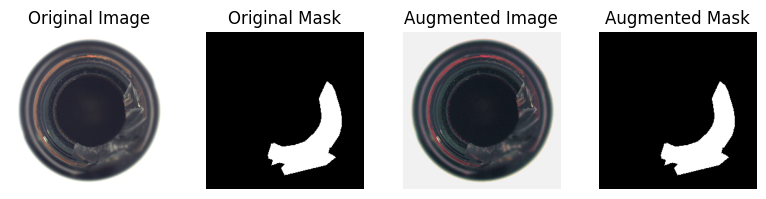

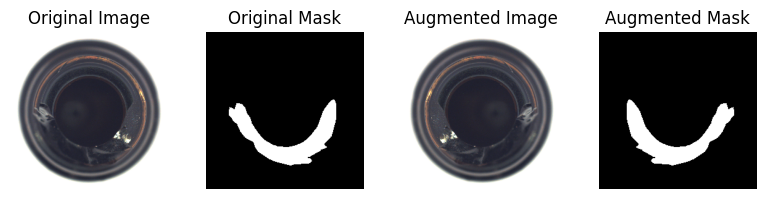

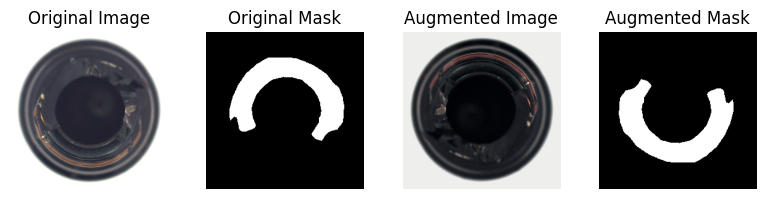

In [44]:
visualize_augmentations(dataset, num_samples=3)

Split the dataset in train, test and validation:

In [25]:
val_size = int(0.2 * len(dataset))  # 20% for validation
test_size = int(0.2 * len(dataset))  # 20% for test
train_size = len(dataset) - val_size - test_size  # rest for train
train_dataset, val_dataset, test_dataset = random_split(
    dataset=dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

Create the train, test and validation dataloaders:

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Evaluation

Define a method to evaluate the model:

In [ ]:
@torch.no_grad()
def evaluate(
        model: U2NetMini,
        loader: DataLoader,
        criterion: nn.Module
    ) -> dict[str, float]:
    """
    Evaluate model on given dataloader and return average loss, perplexity and accuracy.\n
    ---
    ### Args
    - `model` (`U2NetMini`): model to evaluate.
    - `loader` (`DataLoader`): dataloader to evaluate on.
    - `criterion` (`nn.Module`): criterion to evaluate on.\n
    ---
    ### Returns
    - `dict[str, float]`: dictionary containing average loss, perplexity and accuracy.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.autocast(device_type=DEVICE.type):  # Use autocast for mixed precision evaluation
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for images, masks in progress_bar:
            images: Tensor = images.to(DEVICE)
            masks: Tensor = masks.to(DEVICE)

            # Skip batch if masks are empty (no defects)
            if masks.sum() == 0:
                continue

            predictions = model(images)
            loss = criterion(predictions, masks)

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
            progress_bar.set_postfix(batch_loss=loss.item())

    avg_loss = total_loss / max(total_samples, 1)
    return avg_loss

### Training

#### **Training Loop**

The training loop is the core routine where the model learns from the dataset by optimizing its parameters through gradient descent.

#### **Key Steps per Epoch**
1. **Training Phase**
   - The model is set to `train` mode.
   - For each batch:
     - Input images and ground truth masks are sent to the device (GPU or CPU).
     - A forward pass computes predicted masks.
     - The **hybrid loss** (Focal Tversky + BCE) is calculated.
     - Gradients are computed and used to update model weights using **Adam**.
     - Mixed precision (`autocast + GradScaler`) is applied for efficiency.

2. **Validation Phase**
   - The model switches to `eval` mode (no dropout or batch norm updates).
   - Validation loss is computed on unseen data, without gradient updates.
   - The scheduler observes this loss to decide if learning rate needs adjustment.

3. **Checkpointing & Early Stopping**
   - If the validation loss improves, the model is saved as the **best checkpoint**.
   - If not, a **patience counter** increases; training stops early if no improvement occurs for several epochs (`EARLY_STOP_PATIENCE`).

In [ ]:
def train(
        model: U2NetMini,
        train_loader: DataLoader,   
        val_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        criterion: nn.Module,
        scheduler: torch.optim.lr_scheduler,
        epochs: int = 10,
        early_stop_patience: int = 5
    ) -> dict[str, list[float]]:
    """ Train the model with the given parameters and data loaders.\n
    ---
    ### Args
    - `model` (`U2NetMini`): model to train.
    - `train_loader` (`DataLoader`): data loader for training data.
    - `val_loader` (`DataLoader`): data loader for validation data.
    - `optimizer` (`torch.optim.Optimizer`): optimizer for training.
    - `criterion` (`nn.Module`): loss function to optimize.
    - `scheduler` (`torch.optim.lr_scheduler`): learning rate scheduler.
    - `epochs` (`int`): number of epochs to train the model (default is `10`s).
    - `early_stop_patience` (`int`): number of epochs to wait for improvement before stopping training early (default is `5`).
    """
    patience_counter = 0  # Set the patience counter to 0 for early stopping
    best_val = float(np.inf)  # Initialize best validation loss to infinity
    history = {'train': [], 'val': []}  # Define the history dictionary to store training and validation losses
    scaler = GradScaler(device=DEVICE.type)  # allow mixed precision on Ampere GPU with CUDA

    try:
        for epoch in range(0, epochs):
            mr_clean()  # Clean up memory at the start of each epoch
            model.train()  # Set model to training mode
            total_train_loss = 0.0
            train_samples = 0
            
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training {epoch+1}/{epochs}", leave=False)
            for step, (images, masks) in progress_bar:
                images: Tensor = images.to(DEVICE)
                masks: Tensor = masks.to(DEVICE)

                # Skip batch if masks are empty (no defects)
                if masks.sum() == 0:
                    continue

                optimizer.zero_grad()
                with autocast(device_type=DEVICE.type):  # Use autocast for mixed precision training
                    preds: Tensor = model(images)
                    loss: Tensor = criterion(preds, masks)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_train_loss += loss.item() * images.size(0)
                train_samples += images.size(0)
                
                avg_train_loss = total_train_loss / max(train_samples, 1)
                progress_bar.set_postfix(batch_loss=loss.item(), epoch_loss=avg_train_loss)
            
            history['train'].append(avg_train_loss)

            # Validation
            avg_val_loss = evaluate(model, val_loader, criterion)
            history['val'].append(avg_val_loss)
            scheduler.step(avg_val_loss)

            # Early stopping
            is_best = avg_val_loss < best_val - 1e-4  # Check if the current validation loss is better than the best so far
            
            # Save the best model if it improves
            if is_best:
                best_val = avg_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
                save_ckpt("best", model, optimizer, epoch+1, 0, best_val)
                print(f"Epoch [{epoch+1}/{epochs}] - Train loss: {avg_train_loss:.4f} - Val loss: {avg_val_loss:.4f} - BEST")
                
            # Save the latest model state otherwise
            else:
                patience_counter += 1
                save_ckpt("latest", model, optimizer, epoch+1, 0, best_val)
                print(f"Epoch [{epoch+1}/{epochs}] - Train loss: {avg_train_loss:.4f} - Val loss: {avg_val_loss:.4f} - No improvements [{patience_counter}/{early_stop_patience}]")
                
                # Check for early stopping
                if patience_counter >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch}")
                    model.load_state_dict(best_model_state)
                    break
                
        return history  # Return the training history after all epochs are completed

    # If interrupted, save the current state
    except KeyboardInterrupt:
        print("Training interrupted by user.")
        save_ckpt("interrupt", model, optimizer, epoch, step, best_val)
        return history
    
    finally:
        model.load_state_dict(best_model_state)
        return history

In [29]:
history = train(model, train_loader, val_loader, optimizer, criterion, scheduler, EPOCHS, EARLY_STOP_PATIENCE)

Training 1/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1/150] - Train loss: 1.6468 - Val loss: 9.1690 - BEST


Training 2/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2/150] - Train loss: 1.5354 - Val loss: 1.5203 - BEST


Training 3/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3/150] - Train loss: 1.4706 - Val loss: 1.3882 - BEST


Training 4/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4/150] - Train loss: 1.4061 - Val loss: 1.4067 - No improvements [1/5]


Training 5/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5/150] - Train loss: 1.3514 - Val loss: 1.3232 - BEST


Training 6/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6/150] - Train loss: 1.3046 - Val loss: 1.5954 - No improvements [1/5]


Training 7/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7/150] - Train loss: 1.2617 - Val loss: 1.2326 - BEST


Training 8/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8/150] - Train loss: 1.2284 - Val loss: 1.1901 - BEST


Training 9/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9/150] - Train loss: 1.1841 - Val loss: 1.4323 - No improvements [1/5]


Training 10/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10/150] - Train loss: 1.1719 - Val loss: 1.1778 - BEST


Training 11/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11/150] - Train loss: 1.1281 - Val loss: 1.1889 - No improvements [1/5]


Training 12/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12/150] - Train loss: 1.0918 - Val loss: 1.0952 - BEST


Training 13/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13/150] - Train loss: 1.0808 - Val loss: 1.0579 - BEST


Training 14/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14/150] - Train loss: 1.0533 - Val loss: 1.0611 - No improvements [1/5]


Training 15/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15/150] - Train loss: 1.0252 - Val loss: 1.0479 - BEST


Training 16/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16/150] - Train loss: 1.0126 - Val loss: 1.0459 - BEST


Training 17/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17/150] - Train loss: 0.9914 - Val loss: 0.9897 - BEST


Training 18/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18/150] - Train loss: 0.9820 - Val loss: 0.9972 - No improvements [1/5]


Training 19/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19/150] - Train loss: 0.9705 - Val loss: 0.9423 - BEST


Training 20/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20/150] - Train loss: 0.9400 - Val loss: 0.9230 - BEST


Training 21/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21/150] - Train loss: 0.9248 - Val loss: 0.9119 - BEST


Training 22/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22/150] - Train loss: 0.9292 - Val loss: 0.9068 - BEST


Training 23/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23/150] - Train loss: 0.9076 - Val loss: 0.8989 - BEST


Training 24/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24/150] - Train loss: 0.8877 - Val loss: 0.8928 - BEST


Training 25/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25/150] - Train loss: 0.8686 - Val loss: 0.8469 - BEST


Training 26/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26/150] - Train loss: 0.8530 - Val loss: 0.8463 - BEST


Training 27/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27/150] - Train loss: 0.8438 - Val loss: 0.9101 - No improvements [1/5]


Training 28/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28/150] - Train loss: 0.8486 - Val loss: 0.8434 - BEST


Training 29/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29/150] - Train loss: 0.8234 - Val loss: 0.8133 - BEST


Training 30/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30/150] - Train loss: 0.8209 - Val loss: 1.2099 - No improvements [1/5]


Training 31/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31/150] - Train loss: 0.8136 - Val loss: 0.7884 - BEST


Training 32/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32/150] - Train loss: 0.7975 - Val loss: 0.8208 - No improvements [1/5]


Training 33/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33/150] - Train loss: 0.8005 - Val loss: 0.7747 - BEST


Training 34/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34/150] - Train loss: 0.7938 - Val loss: 0.8159 - No improvements [1/5]


Training 35/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35/150] - Train loss: 0.7914 - Val loss: 0.8102 - No improvements [2/5]


Training 36/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36/150] - Train loss: 0.7803 - Val loss: 0.7951 - No improvements [3/5]


Training 37/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37/150] - Train loss: 0.7684 - Val loss: 0.7600 - BEST


Training 38/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38/150] - Train loss: 0.7630 - Val loss: 0.7504 - BEST


Training 39/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39/150] - Train loss: 0.7449 - Val loss: 0.7314 - BEST


Training 40/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40/150] - Train loss: 0.7459 - Val loss: 0.7338 - No improvements [1/5]


Training 41/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41/150] - Train loss: 0.7472 - Val loss: 0.7268 - BEST


Training 42/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42/150] - Train loss: 0.7407 - Val loss: 0.7418 - No improvements [1/5]


Training 43/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43/150] - Train loss: 0.7352 - Val loss: 0.7191 - BEST


Training 44/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44/150] - Train loss: 0.7348 - Val loss: 0.7496 - No improvements [1/5]


Training 45/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45/150] - Train loss: 0.7286 - Val loss: 0.7198 - No improvements [2/5]


Training 46/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46/150] - Train loss: 0.7294 - Val loss: 0.7377 - No improvements [3/5]


Training 47/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47/150] - Train loss: 0.7180 - Val loss: 0.7036 - BEST


Training 48/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48/150] - Train loss: 0.7138 - Val loss: 0.6959 - BEST


Training 49/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49/150] - Train loss: 0.7087 - Val loss: 0.7016 - No improvements [1/5]


Training 50/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50/150] - Train loss: 0.7090 - Val loss: 0.7089 - No improvements [2/5]


Training 51/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51/150] - Train loss: 0.7113 - Val loss: 0.6872 - BEST


Training 52/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52/150] - Train loss: 0.7001 - Val loss: 0.6869 - BEST


Training 53/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53/150] - Train loss: 0.7053 - Val loss: 0.6943 - No improvements [1/5]


Training 54/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54/150] - Train loss: 0.7020 - Val loss: 0.7082 - No improvements [2/5]


Training 55/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55/150] - Train loss: 0.7062 - Val loss: 0.6865 - BEST


Training 56/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56/150] - Train loss: 0.7045 - Val loss: 0.6886 - No improvements [1/5]


Training 57/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57/150] - Train loss: 0.7045 - Val loss: 0.7197 - No improvements [2/5]


Training 58/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58/150] - Train loss: 0.6981 - Val loss: 0.6861 - BEST


Training 59/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59/150] - Train loss: 0.6958 - Val loss: 0.6865 - No improvements [1/5]


Training 60/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60/150] - Train loss: 0.6913 - Val loss: 0.6779 - BEST


Training 61/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61/150] - Train loss: 0.6901 - Val loss: 0.6747 - BEST


Training 62/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62/150] - Train loss: 0.6930 - Val loss: 0.6849 - No improvements [1/5]


Training 63/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63/150] - Train loss: 0.6894 - Val loss: 0.6812 - No improvements [2/5]


Training 64/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64/150] - Train loss: 0.6858 - Val loss: 0.6738 - BEST


Training 65/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65/150] - Train loss: 0.6852 - Val loss: 0.6751 - No improvements [1/5]


Training 66/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66/150] - Train loss: 0.6864 - Val loss: 0.6825 - No improvements [2/5]


Training 67/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67/150] - Train loss: 0.6813 - Val loss: 0.6659 - BEST


Training 68/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68/150] - Train loss: 0.6873 - Val loss: 0.6947 - No improvements [1/5]


Training 69/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69/150] - Train loss: 0.6958 - Val loss: 0.6880 - No improvements [2/5]


Training 70/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70/150] - Train loss: 0.6890 - Val loss: 0.6705 - No improvements [3/5]


Training 71/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71/150] - Train loss: 0.6788 - Val loss: 0.6749 - No improvements [4/5]


Training 72/150:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72/150] - Train loss: 0.6765 - Val loss: 0.6675 - No improvements [5/5]
Early stopping at epoch 71


Plot the train and validation history (losses):

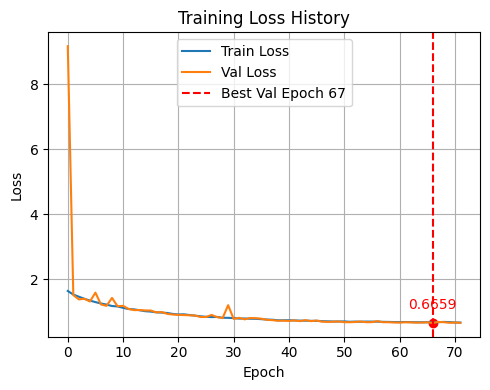

In [30]:
plot_history(history)

---

## Testing & Evaluation

We define the `predict` method to evaluate segmentation performance on the test dataset.

In [ ]:
@torch.no_grad()
def predict(
        model: nn.Module, 
        loader: DataLoader
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Predict masks for images in the given dataloader using the provided model.\n
    ---
    ### Args
    - `model` (`nn.Module`): model to use for predictions.
    - `loader` (`DataLoader`): dataloader containing images to predict.\n
    ---
    ### Returns
    - `Tuple[np.ndarray, np.ndarray, np.ndarray]`: tuple containing images, predictions, and ground truths.
    """
    model.eval()
    all_predictions = []
    all_ground_truths = []
    all_images = []

    for images, masks in tqdm(loader, desc="Predicting"):
        images: Tensor = images.to(DEVICE)
        masks: Tensor = masks.to(DEVICE)

        with autocast(device_type=DEVICE.type):
            logits = model(images)
            probs = torch.sigmoid(logits)

        all_predictions.append(probs.cpu())
        all_ground_truths.append(masks.cpu())
        all_images.append(images.cpu())  # ← salva anche le immagini originali

    predictions = torch.cat(all_predictions, dim=0).numpy()
    ground_truths = torch.cat(all_ground_truths, dim=0).numpy()
    images = torch.cat(all_images, dim=0).numpy()

    return images, predictions, ground_truths

In [118]:
images, predictions, ground_truths = predict(model, test_loader)

Predicting:   0%|          | 0/11 [00:00<?, ?it/s]

In our segmentation task, **defects occupy only a small portion of the image pixels**. Calculating the `F1 score` over all pixels would be **misleading**. We then use a filtered version.

**F1 Score**
- It combines **Precision** and **Recall** into a single metric.
- Useful when dealing with **class imbalance** (e.g., very few defective pixels).
- Formula:  
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

**Why filtering F1 score?**
- Most pixels are **negative** (non-defective/background).
- Evaluating these “easy” pixels would **inflate performance**.
- With filtered F1:
  - We consider **only relevant pixels** (where there’s either predicted or true defect).
  - It measures **how well the model detects actual defects**.
  - It ignores irrelevant background regions that dominate the image.

In [119]:
def compute_filtered_f1(
        predictions: np.ndarray,
        ground_truths: np.ndarray,
        threshold: float
    ) -> float:
    """
    Compute filtered pixel-wise F1 score for a given threshold.\n
    ---
    ### Args
    - `threshold` (`float`): threshold value to apply on predictions.\n
    ---
    ### Returns
    - `float`: filtered F1 score.
    """
    # Ensure predictions are binary based on the threshold
    binary_predictions = (predictions > threshold).astype(np.uint8).flatten()
    # Ground truths are already binary, but we ensure they are in the same format
    binary_ground_truths = (ground_truths > 0.5).astype(np.uint8).flatten()
    # Create a mask to filter out pixels where either prediction or ground truth is zero
    # This mask will only keep pixels where at least one of the two is non-zero
    mask = (binary_predictions + binary_ground_truths) > 0
    # # If no pixels are predicted or ground truth, return 0.0 to avoid division by zero
    if mask.sum() == 0:
        return 0.0
    # Compute F1 score using the filtered predictions and ground truths
    # Use the mask to filter out pixels where both prediction and ground truth are zero
    return f1_score(binary_ground_truths[mask], binary_predictions[mask], zero_division=0)

The model outputs a **probability map** for each image, where each pixel represents the likelihood of being defective.
However, to generate a **binary mask** (defect vs. no defect), we must apply a **threshold** to these probabilities.

**Why thresholding?**
- Too **low** a threshold -> many **false positives** (background misclassified as defect).
- Too **high** a threshold -> many **false negatives** (real defects missed).
- The right threshold improves the **accuracy** and **reliability** of segmentation results.

**How do we choose the best threshold?**
- We compute the **Filtered F1 Score** across a range of thresholds (e.g., `0.01` to `0.99`).
- We ignore irrelevant background pixels by considering only the **active** regions (where prediction or ground truth is positive).
- We use a **two-step grid search**:
  1. **Coarse Search** over a wide range.
  2. **Fine Search** around the best coarse value to refine it further.

> This procedure selects the threshold that **maximizes F1** on the test set, ensuring the best trade-off between sensitivity and specificity.

In [ ]:
def find_best_threshold(
        predictions: np.ndarray,
        ground_truths: np.ndarray,
        coarse_range: np.ndarray = np.linspace(0.01, 0.99, 30),
        refine_range: float = 0.05
    ) -> float:
    """
    Find the best threshold for filtering predictions based on pixel-wise F1 score.\n
    ---
    ### Args
    - `predictions` (`np.ndarray`): model predictions (logits).
    - `ground_truths` (`np.ndarray`): ground truth binary masks.
    - `coarse_range` (`np.ndarray`): range of thresholds for coarse grid search (default is from 0.01 to 0.99 with 30 points).
    - `refine_range` (`float`): range around the best threshold for refined grid search (default is 0.05).\n
    ---
    ### Returns
    - `float`: best threshold value that maximizes the filtered pixel-wise F1 score.
    """
    # Step 1: Coarse grid search
    f1_scores = [compute_filtered_f1(predictions, ground_truths, t) for t in coarse_range]
    best_idx = int(np.argmax(f1_scores))
    best_threshold = coarse_range[best_idx]

    # Step 2: Refined grid search around best threshold
    lower = max(0.0, best_threshold - refine_range)
    upper = min(1.0, best_threshold + refine_range)
    fine_range = np.linspace(lower, upper, 25)
    fine_scores = [compute_filtered_f1(predictions, ground_truths, t) for t in fine_range]
    best_refined_threshold = fine_range[int(np.argmax(fine_scores))]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(coarse_range, f1_scores, label="Coarse")
    plt.plot(fine_range, fine_scores, label="Refined", linestyle='--')
    plt.axvline(best_refined_threshold, color='r', linestyle='--', label=f"Best: {best_refined_threshold:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Filtered Pixel-wise F1")
    plt.title("Threshold Optimization")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"[Best F1] {np.max(fine_scores):.4f} at threshold = {best_refined_threshold:.3f}")
    return best_refined_threshold

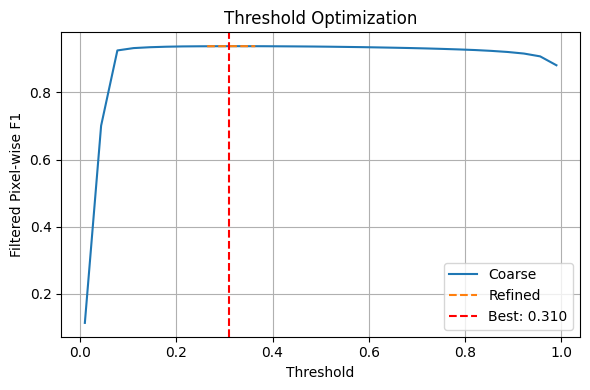

[Best F1] 0.9375 at threshold = 0.310


In [121]:
best_threshold = find_best_threshold(predictions, ground_truths)

Once the model has been trained and the optimal threshold has been found, we evaluate its performance on the test set using multiple tools that help verify that the model generalizes well and provide a clear, measurable evaluation of its segmentation capabilities.

**Segmentation Metrics**
- Quantifies the model's performance with standard pixel-level metrics:
  - **Pixel Accuracy** - how many pixels were classified correctly.
  - **Dice Score** - overlap between prediction and ground truth.
  - **IoU (Intersection over Union)** - strict overlap measurement.
  - **Precision** - how many predicted defects are actually defects.
  - **Recall** - how many true defects are detected.
  - **F1 Score** - balance between precision and recall.

In [ ]:
def get_metrics(
        predictions: np.ndarray,
        ground_truths: np.ndarray,
        threshold: float = 0.5
    ) -> dict[str, float]:
    """
    Compute segmentation metrics including pixel accuracy, Dice score, IoU, precision, recall, and F1 score.\n
    ---
    ### Args
    - `predictions` (`np.ndarray`): model predictions (logits).
    - `ground_truths` (`np.ndarray`): ground truth binary masks.
    - `threshold` (`float`): threshold value to apply on predictions (default is `0.5`).\n
    ---
    ### Returns
    - `dict[str, float]`: dictionary containing computed metrics.
    """
    binary_preds = (predictions > threshold).astype(np.uint8).flatten()
    binary_truths = (ground_truths > 0.5).astype(np.uint8).flatten()

    accuracy = accuracy_score(binary_truths, binary_preds)
    precision = precision_score(binary_truths, binary_preds, zero_division=0)
    recall = recall_score(binary_truths, binary_preds, zero_division=0)
    f1 = f1_score(binary_truths, binary_preds, zero_division=0)

    intersection = np.logical_and(binary_preds, binary_truths).sum()
    union = np.logical_or(binary_preds, binary_truths).sum()
    iou = intersection / (union + 1e-6)
    dice = (2 * intersection) / (binary_preds.sum() + binary_truths.sum() + 1e-6)

    metrics = {
        "Pixel Accuracy": accuracy,  # how many pixels are correctly classified
        "Dice Score": dice,  # how well the predicted mask matches the ground truth
        "IoU": iou,  # Intersection over Union, a measure of overlap between predicted and ground truth masks
        "Precision": precision,  # how many predicted positive pixels are actually positive
        "Recall": recall,  # how many actual positive pixels are correctly predicted
        "F1 Score": f1  # harmonic mean of precision and recall, balancing both metrics
    }
    for k, v in metrics.items():
        print(f"{k:<16}: {v:.4f}")
    return metrics

In [ ]:
metrics = get_metrics(predictions, ground_truths, best_threshold)

Pixel Accuracy  : 0.9956
Dice Score      : 0.9375
IoU             : 0.8824
Precision       : 0.9445
Recall          : 0.9306
F1 Score        : 0.9375


**Visualization of Predictions**
- Displays side-by-side:
  - The input image.
  - The predicted binary mask from the model.
  - The ground truth mask.
- Helps to qualitatively assess segmentation performance and identify common failure cases.

In [ ]:
def show_sample(
        image: Tensor,
        predicted_mask: Tensor,
        ground_truth_mask: Tensor,
        title: str = ""
    ) -> None:
    """
    Show a sample image with its predicted mask and ground truth mask.\n
    ---
    ### Args
    - `image` (`Tensor`): input image tensor.
    - `predicted_mask` (`Tensor`): predicted mask tensor.
    - `ground_truth_mask` (`Tensor`): ground truth mask tensor.\n
    """
    # Ensure the image is on CPU and denormalized
    image = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image.cpu().permute(1, 2, 0).numpy().clip(0, 1)
    
    # Ensure masks are on CPU and converted to numpy arrays
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    ground_truth_mask = ground_truth_mask.squeeze().cpu().numpy()
    
    # Plot the image, predicted mask, and ground truth mask
    _, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[1].imshow(predicted_mask, cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[2].imshow(ground_truth_mask, cmap="gray")
    axs[2].set_title("Ground Truth Mask")
    
    if title:
        plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(
        predictions: np.ndarray,
        ground_truths: np.ndarray,
        images: np.ndarray,
        threshold: float = 0.5,
        max_samples: int = 5
    ) -> None:
    """
    Visualize predictions and ground truths for a subset of images.\n
    ---
    ### Args
    - `predictions` (`np.ndarray`): model predictions (N, H, W).
    - `ground_truths` (`np.ndarray`): ground truth masks (N, H, W).
    - `images` (`np.ndarray`): input images (N, C, H, W).
    - `threshold` (`float`): threshold for binary segmentation (default is '0.5').
    - `max_samples` (`int`): maximum number of samples to visualize (default is '5').
    """
    shown = 0
    for i in range(len(predictions)):
        if ground_truths[i].sum() == 0:
            continue  # mostra solo esempi con difetti

        image_tensor = torch.tensor(images[i])
        pred_mask = (predictions[i] > threshold).astype(np.uint8)
        gt_mask = (ground_truths[i] > 0.5).astype(np.uint8)

        show_sample(
            image_tensor,
            torch.tensor(pred_mask).unsqueeze(0).float(),
            torch.tensor(gt_mask).unsqueeze(0).float()
        )

        shown += 1
        if shown >= max_samples:
            break

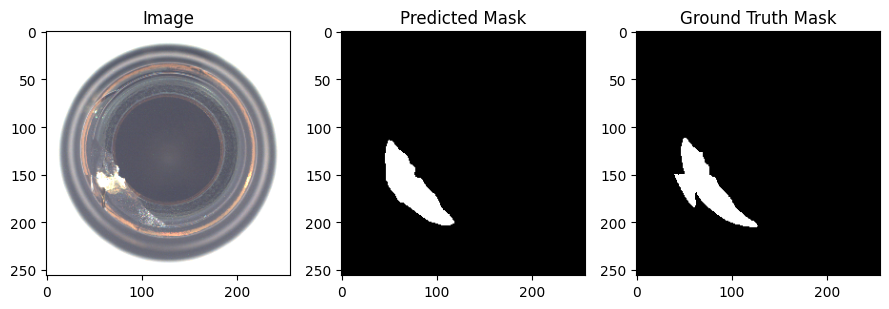

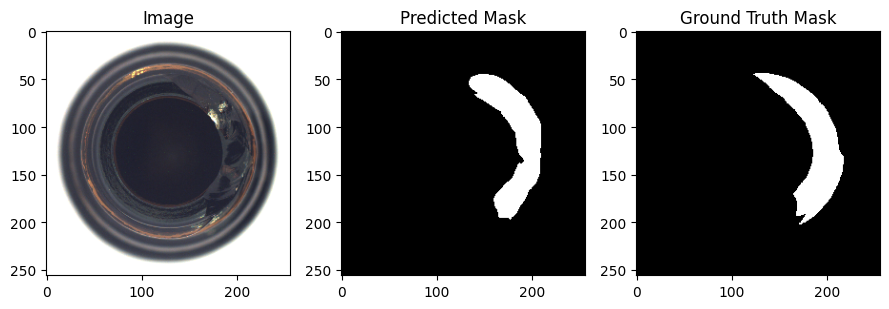

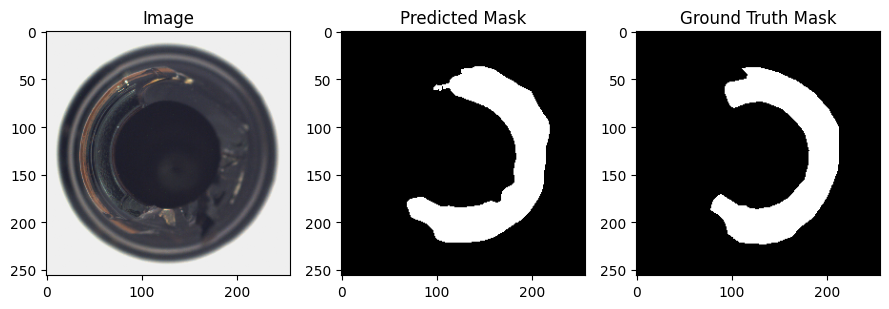

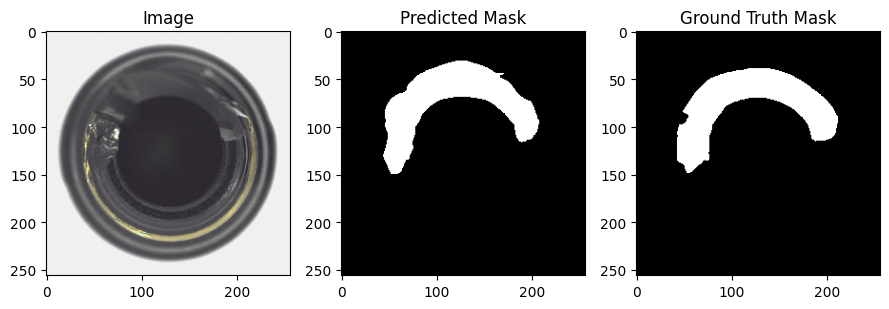

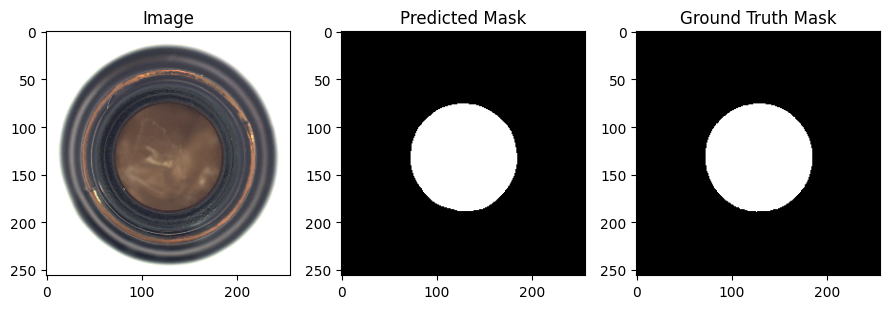

In [127]:
visualize_predictions(predictions, ground_truths, images, best_threshold, max_samples=5)

In [ ]:
def visualize_errors(
        predictions: np.ndarray,
        ground_truths: np.ndarray,
        images: np.ndarray,
        threshold: float = 0.5,
        kind: str = "fp",
        max_samples: int = 3
    ) -> None:
    """
    Visualize false positives or false negatives from predictions and ground truths.\n
    ---
    ### Args
    - `predictions` (`np.ndarray`): model predictions (N, 1, H, W).
    - `ground_truths` (`np.ndarray`): ground truth masks (N, 1, H, W).
    - `images` (`np.ndarray`): input images (N, 3, H, W).
    - `threshold` (`float`): threshold for binary classification (default is '0.5').
    - `kind` (`str`): type of error to visualize ('fp' for false positives, 'fn' for false negatives).
    - `max_samples` (`int`): maximum number of samples to show (default is '3').
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_truths = (ground_truths > 0.5).astype(np.uint8)

    shown = 0
    for i in range(len(predictions)):
        predicted_mask: Tensor = binary_predictions[i][0]
        true_mask: Tensor = binary_truths[i][0]

        is_fp = true_mask.sum() == 0 and predicted_mask.sum() > 0
        is_fn = true_mask.sum() > 0 and predicted_mask.sum() == 0

        if (kind == "fp" and is_fp) or (kind == "fn" and is_fn):
            show_sample(
                torch.tensor(images[i]),
                torch.tensor(predicted_mask).unsqueeze(0).float(),
                torch.tensor(true_mask).unsqueeze(0).float(),
                title="False Positive" if kind == "fp" else "False Negative"
            )
            shown += 1

        if shown >= max_samples:
            break

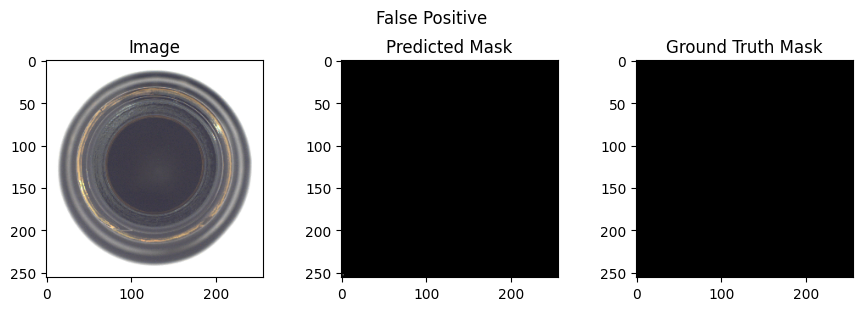

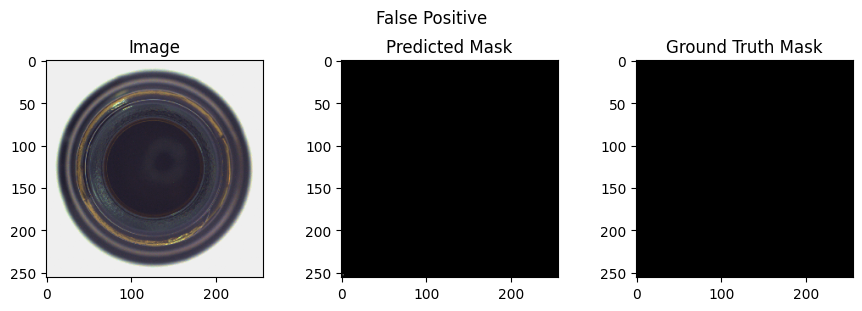

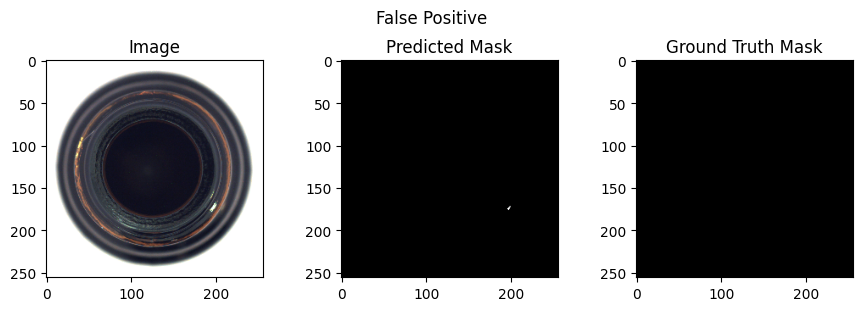

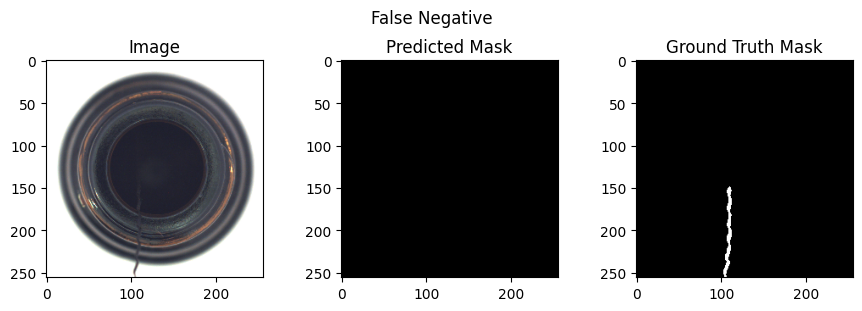

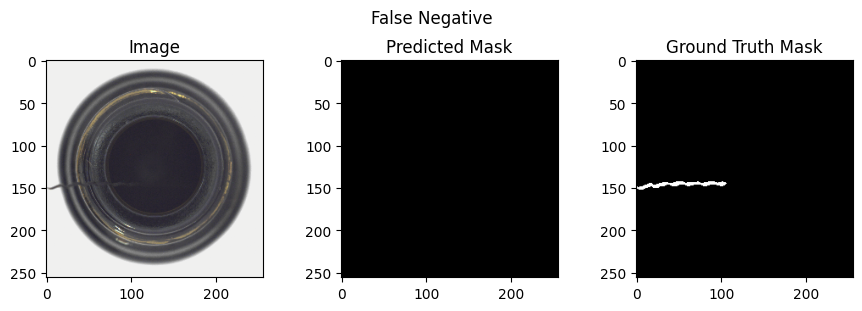

In [131]:
visualize_errors(predictions, ground_truths, images, best_threshold, kind="fp")
visualize_errors(predictions, ground_truths, images, best_threshold, kind="fn")

---

## Conclusions & Future Work

In this project, we tackled the task of **defect segmentation** on plastic bottles from the MVTec AD dataset using a **custom-designed U2NetMini model**, trained **entirely from scratch** without any pretrained backbone, in full compliance with project constraints.

We addressed the **extreme class imbalance** typical of anomaly segmentation by employing a **hybrid loss function** combining **Focal Tversky** and **Binary Cross-Entropy**, and we performed a **grid + fine threshold search** to maximize the filtered pixel-wise F1 score.

### Achievements

- **Custom segmentation model** (`U2NetMini`) trained from scratch on pixel masks, without transfer learning.
- **Hybrid loss strategy** and **early stopping** led to stable convergence.
- **Best threshold** optimized via F1 filtering strategy.
- Final test results show **strong and balanced performance**:
- Visual examples show **very high spatial alignment** between prediction and ground truth for most defect types.

### Observations

- The model performs **exceptionally well on large, high-contrast defects** (`broken_large`, `broken_small`).
- **Minor false positives** occur on complex background textures, confirming the value of Focal Tversky in mitigating noise sensitivity.
- **Some false negatives** are visible in extremely thin or low-contrast defects (e.g., fine cracks or contamination borders).
- **Visualization of failure cases** (false positives/negatives) proved essential in understanding model limitations and guiding future refinements.

### Future Directions

- **Explainability**: Integrate tools like LIME, or attention maps to understand the model’s focus.
- **Multi-class segmentation**: Expand to distinguish between specific defect types.
- **Edge deployment**: Profile inference time and explore pruning or quantization for embedded use.